In [37]:
import pandas as pd
import sys, os, re
import warnings
import numpy as np
import pickle

import torch
from torch.utils.data import DataLoader

from config import *

sys.path.append(f"{ROOT}")
PATH = "/home/malbranke/mutation_data"
warnings.filterwarnings("ignore")

In [38]:
from data_extraction import from_fasta_to_df, from_df_to_fasta, build_profiles
from data_extraction.mutation_data import run_family, run_dataset

from ss_inference.data import SecondaryStructureRawDataset, collate_sequences
from ss_inference.model import NetSurfP2, ConvNet

from pattern_matching.utils import *
from pattern_matching.pattern import *
from pattern_matching.loss import *
from pattern_matching.inference import PatternMatchingInference

In [39]:
meta_df = pd.read_excel(f"{PATH}/meta.xlsx", index_col = 0)

In [40]:
for metadata in meta_df.itertuples():
    print(metadata.Index)
    family = metadata.family
    name_dataset = metadata.dataset
    uniprotid = metadata.uniprot
    exp_columns = re.findall(r"\w\w*", metadata.exp_columns)
    print(f"Family : {family}")
    print(f"Dataset : {name_dataset}")
    print(f"Uniprot ID : {uniprotid}")
    print(f"Experimental Columns : {exp_columns}")
    print("--------------------------")

DYR_ECOLI_Shakhnovich2012
Family : DYR_ECOLI
Dataset : Shakhnovich2012
Uniprot ID : P0ABQ4
Experimental Columns : ['Tm', 'ddG', 'fitness_30', 'fitness_37', 'fitness_42', 'abundance_30', 'abundance_37', 'abundance_42', 'kcatKm_logratio']
--------------------------
POLG_HCVJF_Sun2014
Family : POLG_HCVJF
Dataset : Sun2014
Uniprot ID : Q99IB8
Experimental Columns : ['fitness', 'fitness_daclatasvir']
--------------------------
UBE4B_MOUSE_Klevit2013-singles
Family : UBE4B_MOUSE
Dataset : Klevit2013-singles
Uniprot ID : Q9ES00
Experimental Columns : ['nscor_log2_ratio', 'log2_ratio']
--------------------------
PA_FLU_Sun2015
Family : PA_FLU
Dataset : Sun2015
Uniprot ID : P03433
Experimental Columns : ['RF_index']
--------------------------
BLAT_ECOLX_Palzkill2012
Family : BLAT_ECOLX
Dataset : Palzkill2012
Uniprot ID : P62593
Experimental Columns : ['ddG_stat']
--------------------------
BLAT_ECOLX_Ostermeier2014
Family : BLAT_ECOLX
Dataset : Ostermeier2014
Uniprot ID : P62593
Experimental Co

In [318]:
d = {"A":4,"B":5}

In [320]:
list(d.values())

[4, 5]

In [41]:
name = "PABP_YEAST_Fields2013-singles"
metadata = meta_df.loc[name]
family = metadata.family
name_dataset = metadata.dataset
uniprotid = metadata.uniprot
exp_columns = re.findall(r"\w\w*", metadata.exp_columns)

#family = "PF01353"
#name_dataset = "Sarkisyan2016"
#uniprotid = "P42212"
#exp_columns = re.findall(r"\w\w*", metadata.exp_columns)

In [ ]:
run_family(PATH, family, uniprotid)

In [ ]:
run_dataset(PATH, family, name_dataset)

In [42]:
dataset = SecondaryStructureRawDataset(f"{PATH}/{family}/{name_dataset}_hmm.pkl")

print("Secondary structure")
loader = DataLoader(dataset, batch_size = 1,
                        shuffle=False, drop_last=False, collate_fn = collate_sequences)

device = "cuda"

model_ss3 = NetSurfP2(50, "nsp2")
model_ss3 = model_ss3.to(device)
model_ss3.load_state_dict(torch.load(f"{DATA}/secondary_structure/lstm_50feats.h5"))
print(model_ss3)

Secondary structure
Model nsp2-50


In [43]:
size = 100
Q = torch.load("Q.pt").float()
pi = torch.load("pi.pt")[:,0].float()

seq_hmm = torch.tensor(dataset[0][0]).t()[20:]
torch.save(seq_hmm, f"{PATH}/{family}/hmm.pt")
_, size = seq_hmm.size()


inferer = PatternMatchingInference(model_ss3, Q = Q, pi = pi,
                          seq_hmm = seq_hmm, size = size)

x = torch.tensor(dataset[0][0])[None].permute(0,2,1).float()
m = Matching(x)
p = inferer(m, 1)[0]

p_ = p[:,0]
idx = torch.where(p_<3)[0]
n_pattern = list(p_[idx].numpy())
c_pattern = "".join("abc"[x] for x in p_[idx])

In [44]:
size = 100
Q = np.ones((3, size+1, size+1)) * (-np.inf)
for i in range(size+1):
    Q[:3, i, i+1:] = 0
Q = Q.reshape(1, *Q.shape)

regex = ([(i,None,None) for i in n_pattern])

seq_hmm = torch.tensor(dataset[0][0]).t()[20:]
torch.save(seq_hmm, f"{PATH}/{family}/hmm.pt")
_, size = seq_hmm.size()

matcher = PatternMatching(model_ss3, pattern = regex, Q = Q,
                          seq_hmm = seq_hmm, ss_hmm = None, 
                          size = size, name = c_pattern)

In [45]:
dataset = SecondaryStructureRawDataset(f"{PATH}/{family}/{name_dataset}_hmm.pkl")

print("Secondary structure")
loader = DataLoader(dataset, batch_size = 200,
                        shuffle=False, drop_last=False, collate_fn = collate_sequences)

Secondary structure


In [46]:
from tqdm import tqdm

ls, M, L = [],[],[]
len_pat = len(matcher.pattern)
for batch_idx, data in tqdm(enumerate(loader)):
    x = data[0].permute(0,2,1).float()
    torch.cuda.empty_cache()
    m = Matching(x)
    matcher(m)
    L.append(m.L)
    ls.append(m.ls)
    M.append(m.M)
    del m
ls= torch.cat(ls,0)
M = torch.cat(M,0)
L = torch.cat(L,0)

6it [01:27, 14.59s/it]


In [47]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import *
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import spearmanr, pearsonr, rankdata

import seaborn as sns
sns.set(style="whitegrid", palette="muted")


In [316]:
rho_df = pd.DataFrame(
    columns=["name","fam", "dataset", "exp", "independent", "epistatic", "ssqa", "independent + ssqa", "epistatic + ssqa"])
rho_df = rho_df.set_index("name")
rho_df.to_csv(f"{PATH}/rho_df.csv")


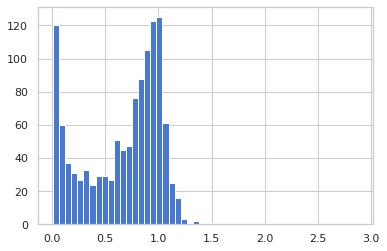

In [48]:
mut_df = pd.read_csv(f"{PATH}/{family}/{name_dataset}_mutation_sequences.csv", index_col = 0)
plt.hist(mut_df.linear, bins = 50)
plt.show()

In [59]:
X_n.abs().size()

torch.Size([1188, 17])

In [96]:
mut_df["M"] = -M/ls
mut_df["is_good"] = 1*mut_df["linear"]<0.3

u = torch.arange(30).view(1,1,-1)
X = (L*u).sum(-1)
m, s = X[mut_df["is_good"]].mean(0)[None], X[mut_df["is_good"]].std(0)[None]
X_n = (X-m)/s
mut_df["div"] = X_n.abs().max(1)[0]

In [274]:
L = L.clamp(0,1)
L_0 = L[mut_df["is_good"]].mean(0)
div = (L_0 * (torch.log(L_0+ 1e-8) - torch.log(L+ 1e-8))).sum(-1)
div = torch.cat([div, torch.tensor(mut_df["effect_prediction_epistatic"].values)[:, None]], axis=1)
div2 = torch.cat([div] + [torch.tensor(rankdata(d, method='ordinal')).view(-1,1) for d in div.T],1)
div2 = (div2 - div2[0])/div2[0].std(0)

In [250]:
print(spearmanr(y, mut_df["effect_prediction_epistatic"])[0])
print(spearmanr(y, mut_df["effect_prediction_independent"])[0])

0.5927805710623181
0.423680083077544


In [267]:
from sklearn.svm import *

In [309]:
N = 25
cv = KFold(n_splits=N, shuffle=True)
y = mut_df["linear"]
pred = np.zeros(len(div2))
clf = SVR()

all_ = 0
for i, (train_index, test_index) in enumerate(cv.split(div2)):

    X_train, X_test = div2[train_index], div2[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    pred[test_index] = clf.predict(X_test)
    print(spearmanr(y_test, clf.predict(X_test))[0])
    all_ += spearmanr(y_test, clf.predict(X_test))[0]
    
print(all_/N)
mut_df["supervised_metric"] = pred

0.5858662613981763
0.4649370386452453
0.6650021710811984
0.6107251411202779
0.8804819800260529
0.5506947459834998
0.6276595744680851
0.6302648719062092
0.5544941380807642
0.6869300911854104
0.5262700825010855
0.7099435518888405
0.5796786799826313
0.5684551341350601
0.6363320999074931
0.5558510638297873
0.6263876040703052
0.5858001850138761
0.5627890841813137
0.7091813135985199
0.5675300647548567
0.6710222016651249
0.6159805735430157
0.6778445883441259
0.5972479185938946
0.617894806396194


Text(0, 0.5, 'Epistatic')

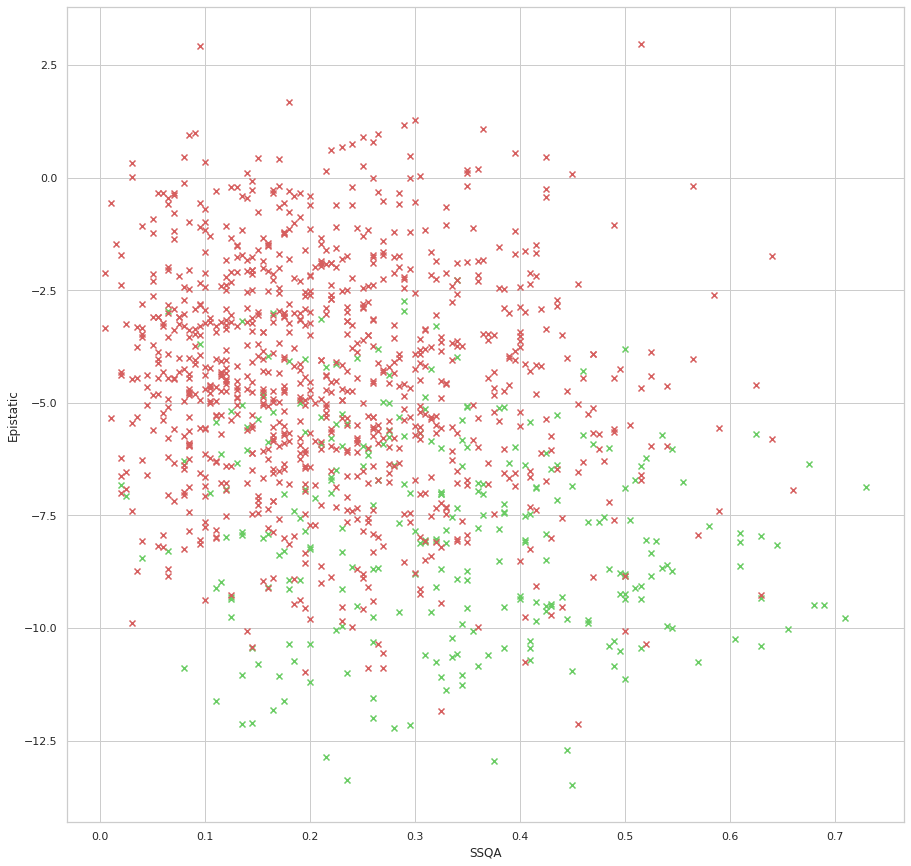

In [183]:
plt.figure(figsize = (15,15))
plt.scatter(pred[mut_df["is_good"]], mut_df[mut_df["is_good"]]["effect_prediction_epistatic"], c = "g", marker = "x")
plt.scatter(pred[~mut_df["is_good"]], mut_df[~mut_df["is_good"]]["effect_prediction_epistatic"], c = "r", marker = "x")
plt.xlabel("SSQA")
plt.ylabel("Epistatic")

In [214]:
x1 = np.linspace(pred.min(),pred.max(),30)[:-1]
x2 = np.linspace(mut_df["effect_prediction_independent"].min(),
                  mut_df["effect_prediction_independent"].max(),30)[:-1]

In [197]:
(mut_df[(pred > i) & (-mut_df["effect_prediction_independent"] > j)]["is_good"]).mean()

0.23524451939291738

In [223]:
from sklearn.metrics import *

In [242]:
acc_ = np.zeros((len(x1), len(x2)))
sum_ = np.zeros((len(x1), len(x2)))
for i,x in enumerate(x1):
    for j,y in enumerate(x2):
        truth = mut_df[(pred > x) & (-mut_df["effect_prediction_independent"] > y)]["is_good"]
        acc_[i,j] = fbeta_score(mut_df["is_good"], 1*((pred > x) & (-mut_df["effect_prediction_independent"] > y)), 0.8)
        sum_[i,j] = (mut_df[(pred > x) & (-mut_df["effect_prediction_independent"] > y)]["is_good"]).sum()

In [243]:
best = acc_.argmax()
x1[best//30], -x2[best%30]

(0.305, 3.8847621258744827)

In [306]:
acc_.max()

0.5138045819463481

Text(0, 0.5, 'Independent')

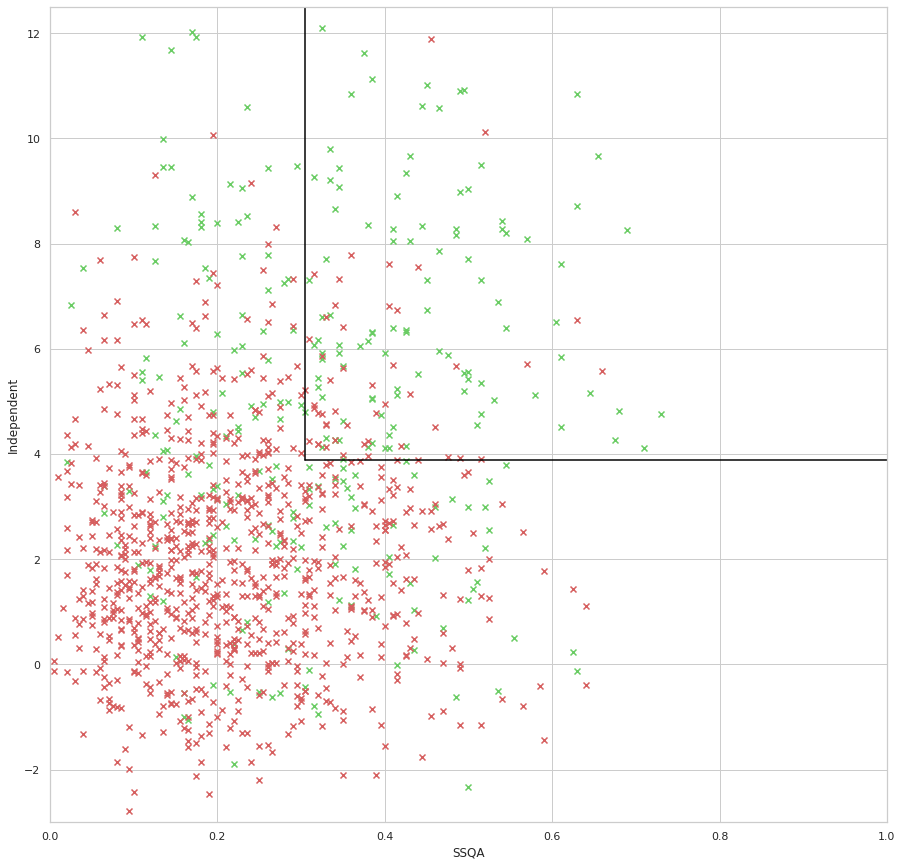

In [244]:
plt.figure(figsize = (15,15))
plt.scatter(pred[mut_df["is_good"]], -mut_df[mut_df["is_good"]]["effect_prediction_independent"], c = "g", marker = "x")
plt.scatter(pred[~mut_df["is_good"]], -mut_df[~mut_df["is_good"]]["effect_prediction_independent"], c = "r", marker = "x")
plt.plot([x1[best//30],1], [-x2[best%30],-x2[best%30]], c="black")
plt.plot([x1[best//30],x1[best//30]], [-x2[best%30],13], c="black")
plt.ylim(-3, 12.5)
plt.xlim(0, 1)
plt.xlabel("SSQA")
plt.ylabel("Independent")

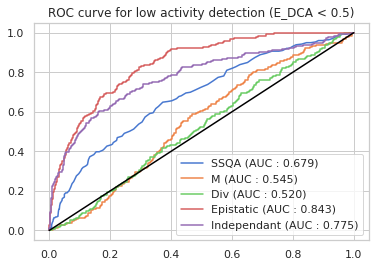

In [133]:
legs = []
fpr, tpr, _ = roc_curve(y, pred)
plt.plot(fpr, tpr)
legs.append(f"SSQA (AUC : {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(y, -mut_df["M"])
plt.plot(fpr, tpr)
legs.append(f"M (AUC : {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(y, -mut_df["div"])
plt.plot(fpr, tpr)
legs.append(f"Div (AUC : {auc(fpr, tpr):.3f})")


fpr, tpr, _ = roc_curve(y, -mut_df["effect_prediction_epistatic"])
plt.plot(fpr, tpr)
legs.append(f"Epistatic (AUC : {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(y, -mut_df["effect_prediction_independent"])
plt.plot(fpr, tpr)
legs.append(f"Independant (AUC : {auc(fpr, tpr):.3f})")

plt.plot([0,1], [0,1], c = "black")
plt.legend(legs)
plt.title(f"ROC curve for low activity detection (E_DCA < 0.5)")

plt.show()

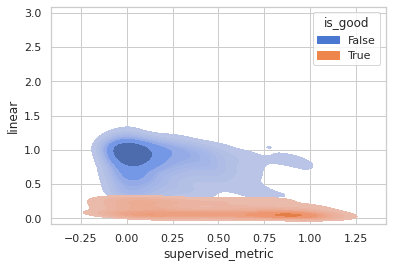

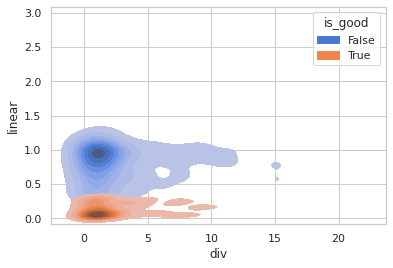

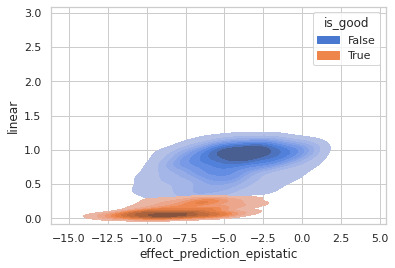

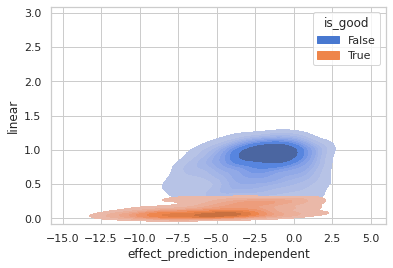

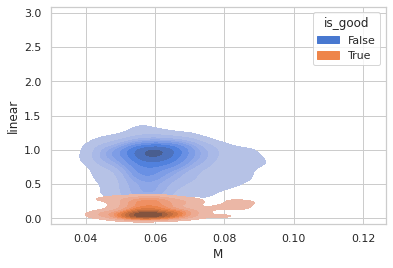

In [123]:
sns.kdeplot(
    data=mut_df, x="supervised_metric", y="linear", hue = "is_good", fill=True,
)
plt.show()

sns.kdeplot(
    data=mut_df, x="div", y="linear", hue = "is_good", fill=True,
)
plt.show()

sns.kdeplot(
    data=mut_df, x="effect_prediction_epistatic", y="linear", hue = "is_good", fill=True,
)
plt.show()

sns.kdeplot(
    data=mut_df, x="effect_prediction_independent", y="linear", hue = "is_good", fill=True,
)
plt.show()


sns.kdeplot(
    data=mut_df, x="M", y="linear", hue = "is_good", fill=True,
)
plt.show()

In [17]:
# GFP

m, s = X[high_bright].mean(0), X[high_bright].std(0)
X_n = (X-m)/s
mut_df["div"] = (X_n.abs().max(1).values - 1)

isnotna = (~mut_df.index.isna())
low_bright = (isnotna) & (mut_df["medianBrightness"] < 2).values
high_bright = (isnotna) & (mut_df["medianBrightness"] > 3).values
mut_df["bright"] = 1*(mut_df["medianBrightness"] >= 2.5)

L = L.clamp(0,1)
L_0 = L[high_bright].mean(0)
div = (L_0 * (torch.log(L_0+ 1e-8) - torch.log(L+ 1e-8))).sum(-1)
div2 = torch.cat([div] + [torch.tensor(rankdata(d, method='ordinal')).view(-1,1) for d in div.t()],1)
div2 = (div2 - div2[high_bright].mean(0))/div2[high_bright].std(0)

plt.plot(div2[high_bright].mean(0))
plt.plot(div2[low_bright].mean(0))
plt.show()

plt.hist(mut_df["medianBrightness"][isnotna], bins = 30)
plt.show()

cv = StratifiedKFold(n_splits=2, shuffle=True)
y = 1*(mut_df["medianBrightness"][low_bright | high_bright]>2.5)
clf =  RandomForestClassifier(200)
pred = np.zeros(len(div2))
for i, (train_index, test_index) in enumerate(cv.split(div2[low_bright | high_bright], y)):
    X_train, X_test = div2[low_bright | high_bright][train_index], div2[low_bright | high_bright][test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    if i == 0:
        pred = clf.predict_proba(div2)[:,1]
    else:
        pred[test_index] = clf.predict_proba(X_test)[:,1]
    print((y_test == clf.predict(X_test)).mean())

mut_df["supervised_metric"] = None
mut_df["supervised_metric"] = pred

ps, rs, f1s = [],[],[]
for t in np.arange(0.,1.01,0.01):
    p, r, f1, _ = precision_recall_fscore_support(1-mut_df["bright"], np.array(pred < t, dtype = int), beta = 2)
    ps.append(p[0]), rs.append(r[0]), f1s.append(f1[0])

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(np.arange(0.,1.01,0.01), ps)
plt.plot(np.arange(0.,1.01,0.01), rs)
plt.plot(np.arange(0.,1.01,0.01), f1s)
plt.legend(["precision", "recall", "f1-score"])
plt.title("precision, recall, f1-score function of the SSQA thresold")

plt.subplot(122)
legs = []
fpr, tpr, _ = roc_curve(mut_df["bright"], pred)
plt.plot(fpr, tpr)
legs.append(f"SSQA (AUC : {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(y, -mut_df["M"][low_bright | high_bright])
plt.plot(fpr, tpr)
legs.append(f"M (AUC : {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(y, -mut_df["div"][low_bright | high_bright])
plt.plot(fpr, tpr)
legs.append(f"Div (AUC : {auc(fpr, tpr):.3f})")

plt.plot([0,1], [0,1], c = "black")
plt.legend(legs)
plt.title(f"ROC curve for low activity detection (E_DCA < 0.5)")

plt.show()

THRES = 0.26
cm = confusion_matrix(1-y, np.array(pred < THRES, dtype = int), normalize = "pred")
sns.set(style="white", palette="muted")
cmd = ConfusionMatrixDisplay(cm, display_labels=["inactive","active"])
ax = cmd.plot(cmap='Greens')
plt.title("Confusion Matrix for low activity detection using SSQA")
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

sns.kdeplot(
    data=mut_df, x="supervised_metric", y="medianBrightness", hue = "bright", fill=True,
)
plt.show()

sns.kdeplot(
    data=mut_df, x="div", y="medianBrightness", hue = "bright", fill=True,
)
plt.xlim(0,10)
plt.show()

sns.kdeplot(
    data=mut_df, x="M", y="medianBrightness", hue = "bright", fill=True,
)
plt.show()